In [1]:
#%matplotlib notebook
%matplotlib widget
from zMag_Field import *
import numpy as np
import matplotlib.animation as animation
from tqdm import tqdm

<IPython.core.display.Javascript object>

In [2]:


def compute_magnetic_force(coil_pillars, position, magnetic_moment, delta=0.001):
    """
    Computes the magnetic force on a dipole at a given position.

    Parameters:
        coil_pillars (list): Coil definitions.
        position (tuple): (x, y, z) coordinates.
        magnetic_moment (tuple): Dipole moment vector (mx, my, mz) in A·m².
        delta (float): Small step for numerical differentiation.

    Returns:
        tuple: Force vector (Fx, Fy, Fz) in Newtons.
    """
    x, y, z = position
    mx, my, mz = magnetic_moment

    def get_B(pos):
        return compute_magnetic_field(coil_pillars, pos)

    # Compute gradient tensor G[i][j] = ∂Bi/∂xj
    G = [[0.0]*3 for _ in range(3)]
    for j, (dx, dy, dz) in enumerate([(delta,0,0), (0,delta,0), (0,0,delta)]):
        B_forward = get_B((x + dx, y + dy, z + dz))
        B_backward = get_B((x - dx, y - dy, z - dz))
        for i in range(3):
            G[i][j] = (B_forward[i] - B_backward[i]) / (2 * delta)

    # Compute force = G ⋅ m
    m_vec = np.array([mx, my, mz])
    G_matrix = np.array(G)
    F = G_matrix @ m_vec

    return tuple(F)



In [3]:
def update_position_velocity(position, velocity, force, mass, dt= 0.005):
    """
    Updates position and velocity using force and time step (basic Newtonian mechanics).
    
    Parameters:
        position (tuple): Current (x, y, z) position.
        velocity (tuple): Current (vx, vy, vz) velocity.
        force (tuple): Force vector (Fx, Fy, Fz).
        mass (float): Mass of the object.
        dt (float): Time step.
    
    Returns:
        tuple: Updated (position, velocity)
    """
    x, y, z = position
    vx, vy, vz = velocity
    Fx, Fy, Fz = force

    # Acceleration
    ax = Fx / mass
    ay = Fy / mass
    az = Fz / mass

    # Update velocity
    vx_new = vx + ax * dt
    vy_new = vy + ay * dt
    vz_new = vz + az * dt

    # Update position
    x_new = x + vx * dt + 0.5 * ax * dt**2
    y_new = y + vy * dt + 0.5 * ay * dt**2
    z_new = z + vz * dt + 0.5 * az * dt**2

    return (x_new, y_new, z_new), (vx_new, vy_new, vz_new)


In [4]:
class PID:
    def __init__(self, kp, ki, kd, setpoint=0.0, output_limits=(-np.inf, np.inf), dt=0.005):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.setpoint = setpoint
        self.output_limits = output_limits
        self.dt = dt
        self._integral = 0
        self._prev_error = 0

    def compute(self, measurement):
        error = self.setpoint - measurement
        self._integral += error * self.dt
        derivative = (error - self._prev_error) / self.dt
        output = self.kp * error + self.ki * self._integral + self.kd * derivative
        self._prev_error = error
        return max(self.output_limits[0], min(self.output_limits[1], output))


In [ ]:
def scale_position_to_hall(x, physical_range=0.025, center=530, hall_range=1023):
    """
    Maps a physical position in meters to a simulated Hall sensor reading.

    Parameters:
        x (float): Physical position (in meters)
        physical_range (float): Max range from center position (e.g., ±0.025 m)
        center (int): Hall sensor value for zero position (default 530)
        hall_range (int): Max value of Hall sensor (default 1023)

    Returns:
        float: Simulated Hall sensor reading
    """
    scale = (hall_range / 2) / physical_range  # Scale m → hall units
    return center + x * scale

def scale_hall_to_position(hall_value, physical_range=0.025, center=530, hall_range=1023):
    """
    Maps a Hall sensor reading back to physical position in meters.

    Parameters:
        hall_value (float): Simulated or real Hall sensor reading (0–1023)
        physical_range (float): Max range from center position (e.g., ±0.025 m)
        center (int): Hall sensor value for zero position (default 530)
        hall_range (int): Max value of Hall sensor (default 1023)

    Returns:
        float: Physical position in meters
    """
    scale = (hall_range / 2) / physical_range  # Same scale as forward mapping
    return (hall_value - center) / scale


: 

In [ ]:
pid_x = PID(kp=0.6, ki=0.0, kd=0.01, setpoint=530, output_limits=(-255, 255))
pid_y = PID(kp=0.6, ki=0.0, kd=0.01, setpoint=530, output_limits=(-255, 255))
x_current = 0
y_current = 0
magnetic_moment = (0.0, 0.0, 2.06)  # A·m²
position = np.array([0.00, -0.02, 0.03])  # Starting position of the magnet
velocity = np.array([0.0, 0.0, 0.0])  # Starting velocity of the magnet
mass = 0.025  # kg
dt = 0.005  # seconds
trajectory = []

# Assume initial coil currents (can start at 0)
current_x = -5.0
current_y = 5

MAX_CURRENT = 7.0  # Amps
MAX_PWM = 255



for step in tqdm(range(40)):
    x, y, z = position
    Input_X = scale_position_to_hall(x)
    Input_Y = scale_position_to_hall(y)


    # 1. PID computes desired current adjustment
    pwm_delta_x = pid_x.compute(Input_X)
    pwm_delta_y = pid_y.compute(Input_Y)
    
    # 2. Convert PWM change to actual current (Amps)
    delta_Ix = (pwm_delta_x / MAX_PWM) * MAX_CURRENT
    delta_Iy = (pwm_delta_y / MAX_PWM) * MAX_CURRENT

    # 2. Update the actual coil currents
    current_x += delta_Ix
    current_y += delta_Iy

    # Max current in Amps (adjust as needed)
    max_current = 5 # e.g., ±3.5 A

    # 2. Update the actual coil currents with limits
    current_x = np.clip(current_x + delta_Ix, -max_current, max_current)
    current_y = np.clip(current_y + delta_Iy, -max_current, max_current)
    # 3. Update the current in the coils
    coil_pillars = construct_system(current_x, current_y)

    # 4. Compute magnetic force at current position
    force = compute_magnetic_force(coil_pillars, position, magnetic_moment)
    force = np.array(force)
    # 5. Zero out Z if we're assuming it's fixed
    force[2] = 0.0
    print(f"Currents: ({current_x:.2f}, {current_y:.2f}), Position: ({x:.3f}, {y:.3f}), Force: {force}")

    # 6. Update position from force
    position, velocity = update_position_velocity(position, velocity , force, mass, dt)
    
    # 7. Save trajectory
    trajectory.append(position)


  0%|          | 1/1000 [00:32<9:08:34, 32.95s/it]

Currents: (0.00, 5.00), Position: (0.000, -0.020), Force: [0.26778122 0.04822923 0.        ]


  0%|          | 2/1000 [01:05<9:02:21, 32.61s/it]

Currents: (-0.39, 5.00), Position: (0.000, -0.020), Force: [0.28891212 0.04560161 0.        ]


  0%|          | 3/1000 [01:37<8:59:09, 32.45s/it]

Currents: (-1.69, 5.00), Position: (0.001, -0.020), Force: [0.35871345 0.03869304 0.        ]


  0%|          | 4/1000 [02:09<8:58:15, 32.43s/it]

Currents: (-4.20, 5.00), Position: (0.001, -0.020), Force: [0.49310872 0.03249716 0.        ]


  0%|          | 5/1000 [02:44<9:07:47, 33.03s/it]

Currents: (-5.00, 5.00), Position: (0.002, -0.020), Force: [0.52820839 0.05187961 0.        ]


  1%|          | 6/1000 [03:16<9:02:04, 32.72s/it]

Currents: (-5.00, 5.00), Position: (0.004, -0.019), Force: [0.50472692 0.08482974 0.        ]


  1%|          | 7/1000 [03:48<8:58:32, 32.54s/it]

Currents: (-5.00, 5.00), Position: (0.006, -0.019), Force: [0.45421018 0.12307865 0.        ]


  1%|          | 8/1000 [04:20<8:55:39, 32.40s/it]

Currents: (-5.00, 5.00), Position: (0.009, -0.019), Force: [0.36683905 0.1596704  0.        ]


  1%|          | 9/1000 [04:52<8:51:18, 32.17s/it]

Currents: (-5.00, 5.00), Position: (0.012, -0.018), Force: [0.24092922 0.18529731 0.        ]


  1%|          | 10/1000 [05:23<8:47:05, 31.94s/it]

Currents: (-5.00, 5.00), Position: (0.015, -0.018), Force: [0.09002222 0.19187001 0.        ]


  1%|          | 11/1000 [05:55<8:44:57, 31.85s/it]

Currents: (-5.00, 5.00), Position: (0.019, -0.017), Force: [-0.05778987  0.17757764  0.        ]


  1%|          | 12/1000 [06:27<8:46:24, 31.97s/it]

Currents: (-5.00, 5.00), Position: (0.023, -0.016), Force: [-0.17337557  0.14862452  0.        ]


  1%|▏         | 13/1000 [06:59<8:45:12, 31.93s/it]

Currents: (-5.00, 5.00), Position: (0.026, -0.015), Force: [-0.24272776  0.11495904  0.        ]


  1%|▏         | 14/1000 [07:32<8:50:33, 32.29s/it]

Currents: (-5.00, 5.00), Position: (0.029, -0.013), Force: [-0.27016899  0.08432693  0.        ]


  2%|▏         | 15/1000 [08:07<9:05:45, 33.24s/it]

Currents: (-5.00, 5.00), Position: (0.032, -0.012), Force: [-0.26922535  0.05999204  0.        ]


  2%|▏         | 16/1000 [08:43<9:15:47, 33.89s/it]

Currents: (-5.00, 5.00), Position: (0.035, -0.010), Force: [-0.25313429  0.04198034  0.        ]


  2%|▏         | 17/1000 [09:18<9:22:58, 34.36s/it]

Currents: (-5.00, 5.00), Position: (0.037, -0.009), Force: [-0.23096744  0.02901628  0.        ]


  2%|▏         | 18/1000 [09:53<9:25:56, 34.58s/it]

Currents: (-5.00, 5.00), Position: (0.040, -0.007), Force: [-0.20777546  0.01968926  0.        ]


  2%|▏         | 19/1000 [10:27<9:22:29, 34.40s/it]

Currents: (-5.00, 4.99), Position: (0.042, -0.005), Force: [-0.18567916  0.01295228  0.        ]


  2%|▏         | 20/1000 [11:01<9:17:33, 34.14s/it]

Currents: (-5.00, 3.83), Position: (0.043, -0.004), Force: [-0.14307512  0.01603197  0.        ]


  2%|▏         | 21/1000 [11:34<9:14:40, 33.99s/it]

Currents: (-5.00, 1.53), Position: (0.045, -0.002), Force: [-0.09168296  0.02627735  0.        ]


  2%|▏         | 22/1000 [12:07<9:08:02, 33.62s/it]

Currents: (-5.00, -1.96), Position: (0.047, -0.000), Force: [-0.03865572  0.0411409   0.        ]


  2%|▏         | 23/1000 [12:41<9:08:27, 33.68s/it]

Currents: (-5.00, -5.00), Position: (0.048, 0.001), Force: [-0.00734607  0.04962021  0.        ]


  2%|▏         | 24/1000 [13:14<9:05:57, 33.56s/it]

Currents: (-5.00, -5.00), Position: (0.049, 0.003), Force: [-0.01485692  0.04088998  0.        ]


  2%|▎         | 25/1000 [13:47<9:02:22, 33.38s/it]

Currents: (-5.00, -5.00), Position: (0.051, 0.005), Force: [-0.02000365  0.0328137   0.        ]


  3%|▎         | 26/1000 [14:19<8:56:16, 33.04s/it]

Currents: (-5.00, -5.00), Position: (0.052, 0.007), Force: [-0.02312168  0.02559296  0.        ]


  3%|▎         | 27/1000 [14:54<9:01:50, 33.41s/it]

Currents: (-5.00, -5.00), Position: (0.054, 0.009), Force: [-0.02458494  0.01932904  0.        ]


  3%|▎         | 28/1000 [15:28<9:07:22, 33.79s/it]

Currents: (-5.00, -5.00), Position: (0.055, 0.010), Force: [-0.02476399  0.01404247  0.        ]


  3%|▎         | 29/1000 [16:03<9:09:19, 33.94s/it]

Currents: (-5.00, -5.00), Position: (0.056, 0.012), Force: [-0.0239983  0.0096947  0.       ]


  3%|▎         | 30/1000 [16:37<9:12:35, 34.18s/it]

Currents: (-5.00, -5.00), Position: (0.058, 0.014), Force: [-0.02258097  0.00620836  0.        ]


  3%|▎         | 31/1000 [17:09<9:01:02, 33.50s/it]

Currents: (-5.00, -5.00), Position: (0.059, 0.016), Force: [-0.02075302  0.00348423  0.        ]


  3%|▎         | 32/1000 [17:42<8:57:51, 33.34s/it]

Currents: (-5.00, -5.00), Position: (0.060, 0.018), Force: [-0.01870422  0.00141445  0.        ]


  3%|▎         | 33/1000 [18:13<8:46:11, 32.65s/it]

Currents: (-5.00, -5.00), Position: (0.061, 0.020), Force: [-0.01657782 -0.00010823  0.        ]


  3%|▎         | 34/1000 [18:44<8:34:05, 31.93s/it]

Currents: (-5.00, -5.00), Position: (0.063, 0.022), Force: [-0.01447716 -0.00118427  0.        ]


  4%|▎         | 35/1000 [19:14<8:25:59, 31.46s/it]

Currents: (-5.00, -5.00), Position: (0.064, 0.024), Force: [-0.01247288 -0.00190389  0.        ]


  4%|▎         | 36/1000 [19:44<8:20:00, 31.12s/it]

Currents: (-5.00, -5.00), Position: (0.065, 0.026), Force: [-0.01060973 -0.00234545  0.        ]


  4%|▎         | 37/1000 [20:16<8:20:02, 31.16s/it]

Currents: (-5.00, -5.00), Position: (0.066, 0.028), Force: [-0.0089128  -0.00257516  0.        ]


  4%|▍         | 38/1000 [20:48<8:25:48, 31.55s/it]

Currents: (-5.00, -5.00), Position: (0.067, 0.030), Force: [-0.00739265 -0.0026477   0.        ]


  4%|▍         | 39/1000 [21:23<8:43:12, 32.67s/it]

Currents: (-5.00, -5.00), Position: (0.068, 0.032), Force: [-0.00604956 -0.00260727  0.        ]


  4%|▍         | 40/1000 [21:58<8:50:30, 33.16s/it]

Currents: (-5.00, -5.00), Position: (0.070, 0.034), Force: [-0.00487692 -0.00248889  0.        ]


  4%|▍         | 41/1000 [22:32<8:55:23, 33.50s/it]

Currents: (-5.00, -5.00), Position: (0.071, 0.036), Force: [-0.0038637 -0.0023198  0.       ]


: 

: 

: 

In [ ]:
def animate_pos_list(positions):
    # Extract x, y, z coordinates
    x_positions = [pos[0] for pos in positions]
    y_positions = [pos[1] for pos in positions]
    z_positions = [pos[2] for pos in positions]

    # Plot setup
    fig, ax = plt.subplots()
    scat = ax.scatter(x_positions[0], z_positions[0], c="b", s=5, label='Particle')
    ax.set(xlim=[min(x_positions) - 0.01, max(x_positions) + 0.01], ylim=[min(z_positions) - 0.01, max(z_positions) + 0.01], xlabel='X', ylabel='Z')
    ax.legend()

    # Update function
    def update(frame):
        x = x_positions[:frame]
        z = z_positions[:frame]
        scat.set_offsets(np.column_stack([x, z]))
        return scat,

    # Create animation
    ani = animation.FuncAnimation(fig, update, frames=len(positions), interval=100, blit=False)
    return ani

In [ ]:
print(trajectory)

[(np.float64(0.0), np.float64(-0.02), np.float64(0.03)), (np.float64(0.0), np.float64(-0.02), np.float64(0.03)), (np.float64(0.0), np.float64(-0.02), np.float64(0.03)), (np.float64(0.0), np.float64(-0.02), np.float64(0.03)), (np.float64(0.0), np.float64(-0.02), np.float64(0.03)), (np.float64(0.0), np.float64(-0.02), np.float64(0.03)), (np.float64(0.0), np.float64(-0.02), np.float64(0.03)), (np.float64(0.0), np.float64(-0.02), np.float64(0.03)), (np.float64(0.0), np.float64(-0.02), np.float64(0.03)), (np.float64(0.0), np.float64(-0.02), np.float64(0.03))]


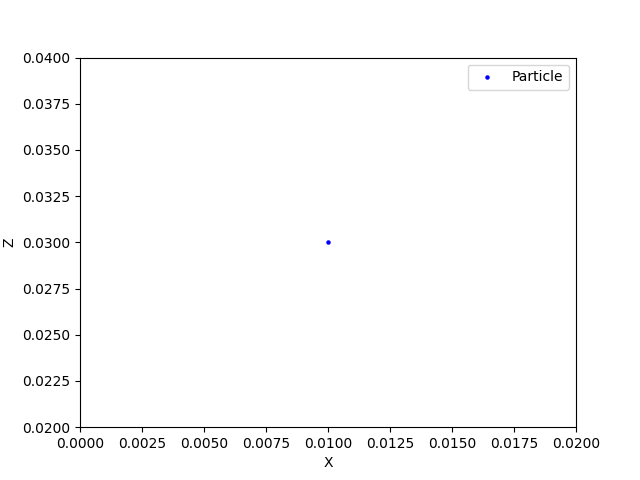

In [ ]:
animate_pos_list(trajectory)